In [17]:
import copy
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from timezonefinder import TimezoneFinder
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error
)
import pickle
import seaborn as sns

In [9]:
DATA_PATH = "data/"
IRRADIANCE_DATA_PATH = DATA_PATH + "psh_irradiance_21-10-15_23-12-30.csv"
WEATHER_DATA_PATH = DATA_PATH + "open-meteo-18.88N99.04E309m.csv"
MODEL_PATH = ""

HISTORY_LENGTH = 2*24
FORECAST_LENGTH = 24

LATITUDE = 18.852
LONGITUDE = 98.994
TIMEZONE = TimezoneFinder().certain_timezone_at(lat=LATITUDE, lng=LONGITUDE)

TIMESTAMP_COLUMN = "timestamp"
IRRAD_COLUMN = "solar_irrad"
SENSOR_TEMP_COLUMN = "module_temp"
# weather
TEMPERATURE = "temperature_2m (°C)"
HUMIDITI = "relative_humidity_2m (%)"
DEW_POINT = "dew_point_2m (°C)"
APPARENT_TEMP = "apparent_temperature (°C)"
RAIN = "rain (mm)"
WEATHERCODE = "weather_code (wmo code)"
PRESURE_MSL = "pressure_msl (hPa)"
SURFACE_PRESURE = "surface_pressure (hPa)"
CLOUDCOVER = "cloud_cover (%)"
CLOUDCOVER_LOW = "cloud_cover_low (%)"
CLOUDCOVER_MID = "cloud_cover_mid (%)"
CLOUDCOVER_HIGH = "cloud_cover_high (%)"
VAPOR_PRESSURE_DEFICIT = "vapour_pressure_deficit (kPa)"
WINDSPEED_10 = "wind_speed_10m (km/h)"
WINDSPEED_100 = "wind_speed_100m (km/h)"
WINDDIRECT_10 = "wind_direction_10m (°)"
WINDDIRECT_100 = "wind_direction_100m (°)"
IS_DAY = "is_day ()"
SUNSHINE_DURATION = "sunshine_duration (s),"
SHORTWAVE_RADIATION = "shortwave_radiation (W/m²)"
DIRECT_RADIATION = "direct_radiation (W/m²)"
DIFFUSE_RADIATION = "diffuse_radiation (W/m²)"
DIRECT_NORMAL_IRRADIANCE = "direct_normal_irradiance (W/m²)"

# Utils

In [18]:
def plot_corr(df):
    for i, method in enumerate(("pearson", "spearman")):
        corr_mat = df.corr(method=method)
        mask = np.zeros_like(corr_mat, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        plt.figure(figsize=(20, 10))
        sns.heatmap(
            data=corr_mat,
            mask=mask,
            annot=True,
            fmt='.2f',
            vmax=1,
            center=0,
            square=True,
            linewidth=.5,
            cbar_kws={'shrink': .5},
        )
        plt.title(method)

def show_info(df: pd.DataFrame):
#     print(df.head())
#     print(df.info())
    df.hist(figsize=(15, 15))
    plot_corr(df)

In [4]:
def get_history(timeseries: pd.DataFrame, timestamp: pd.Timestamp, hours_n: int) -> pd.DataFrame:
    history = timeseries[timestamp - pd.Timedelta(hours=hours_n) : timestamp - pd.Timedelta(hours=1)]
    if len(history) != hours_n:
        return None
    # print(type(history))
    return history

In [5]:
def get_actual_forecast(timeseries: pd.DataFrame, timestamp: pd.Timestamp, hours_n: int) -> pd.DataFrame:
    actual_forecast = timeseries[timestamp : timestamp  + pd.Timedelta(hours=hours_n-1)]
    if len(actual_forecast) != hours_n:
        return None
    # print(type(actual_forecast))
    return actual_forecast

# Data Load

In [6]:
irradiance_ts = pd.read_csv(IRRADIANCE_DATA_PATH, 
                            usecols=[TIMESTAMP_COLUMN, IRRAD_COLUMN, SENSOR_TEMP_COLUMN], 
                            parse_dates=[TIMESTAMP_COLUMN])

In [7]:
irradiance_ts[TIMESTAMP_COLUMN] = pd.to_datetime(irradiance_ts[TIMESTAMP_COLUMN], utc=False)
irradiance_ts[TIMESTAMP_COLUMN] = irradiance_ts[TIMESTAMP_COLUMN].dt.tz_convert(TIMEZONE)
irradiance_ts = irradiance_ts.sort_values(by=TIMESTAMP_COLUMN)
irradiance_ts = irradiance_ts.set_index(TIMESTAMP_COLUMN)

In [10]:
weather_ts = pd.read_csv(WEATHER_DATA_PATH, parse_dates=[TIMESTAMP_COLUMN]) 

In [11]:
weather_ts[TIMESTAMP_COLUMN] = pd.to_datetime(weather_ts[TIMESTAMP_COLUMN], utc=False)
weather_ts[TIMESTAMP_COLUMN] = weather_ts[TIMESTAMP_COLUMN].dt.tz_localize(TIMEZONE)
weather_ts = weather_ts.sort_values(by=TIMESTAMP_COLUMN)
weather_ts = weather_ts.set_index(TIMESTAMP_COLUMN)

In [12]:
irradiance_weather_ts = irradiance_ts.merge(weather_ts, left_index=True, right_index=True)

# EDA

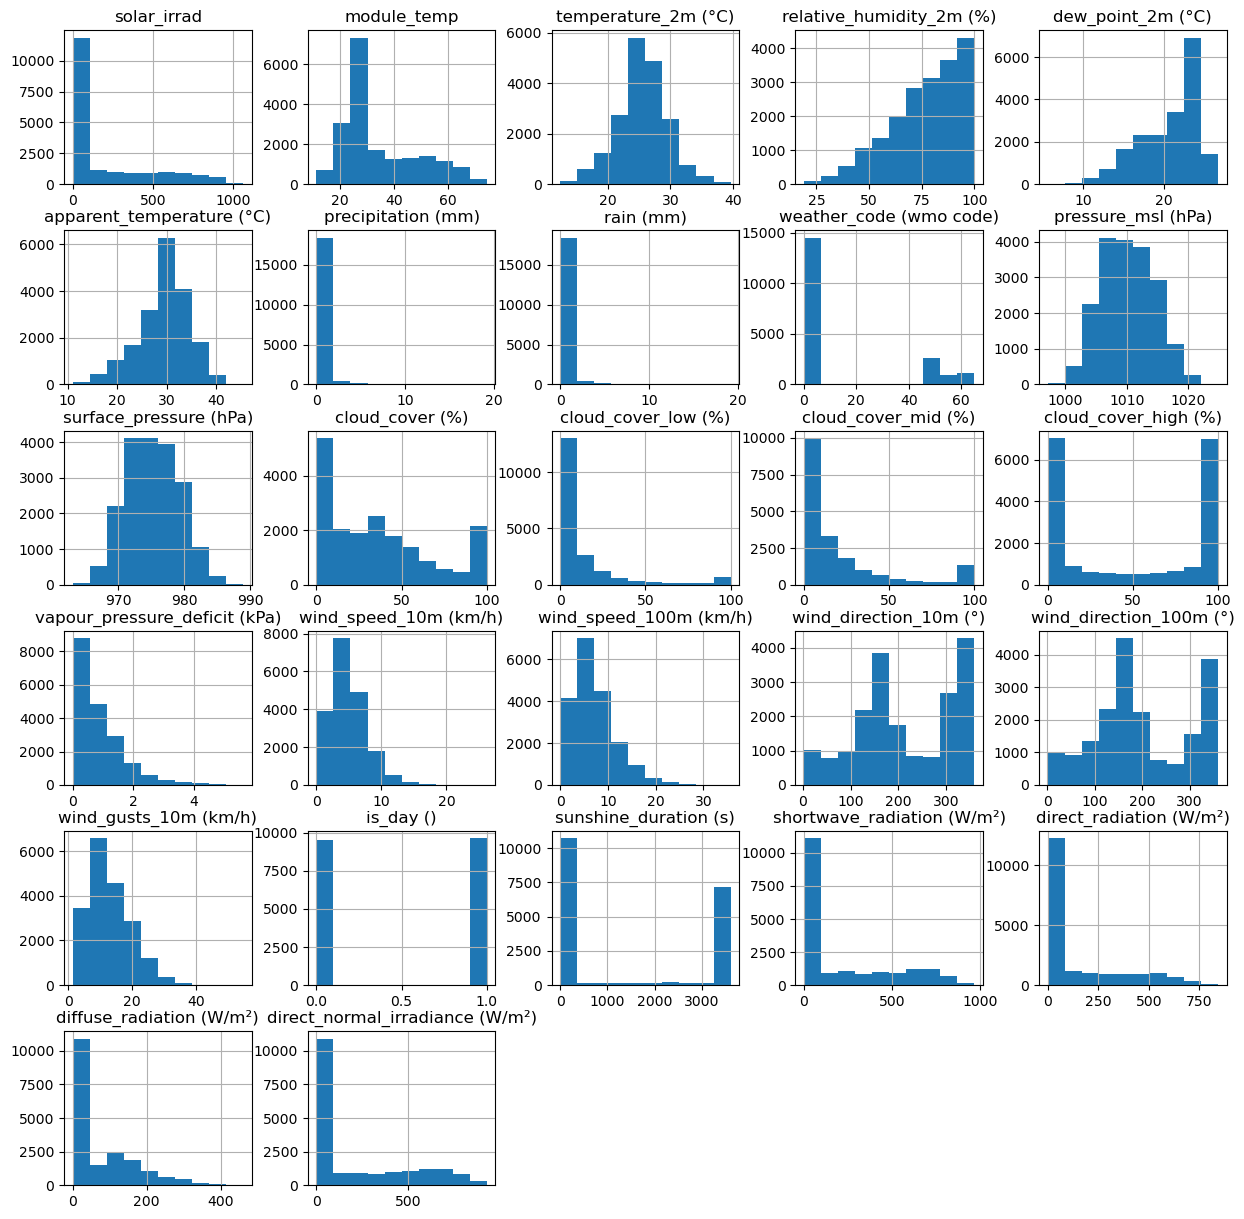

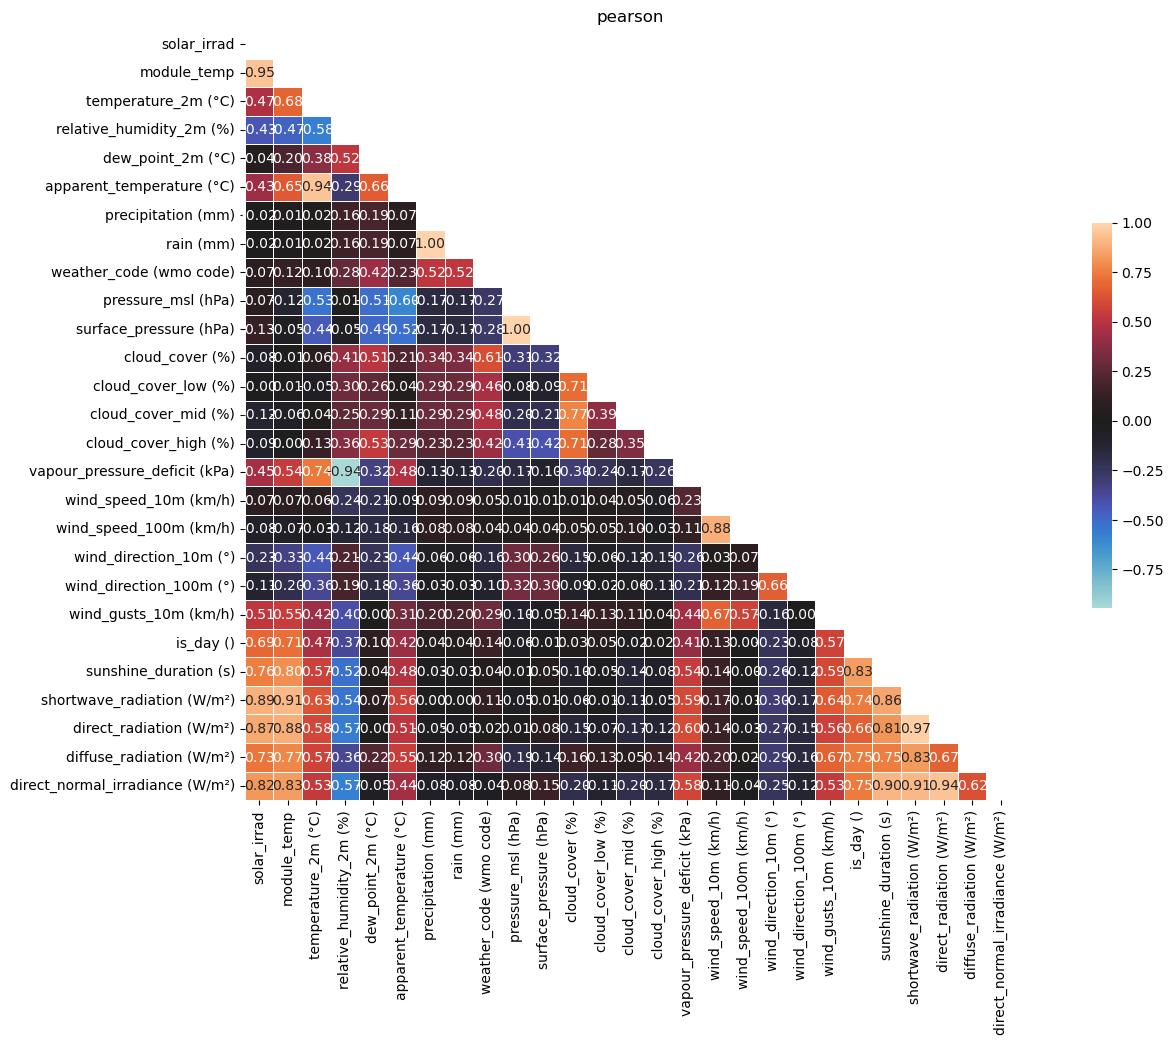

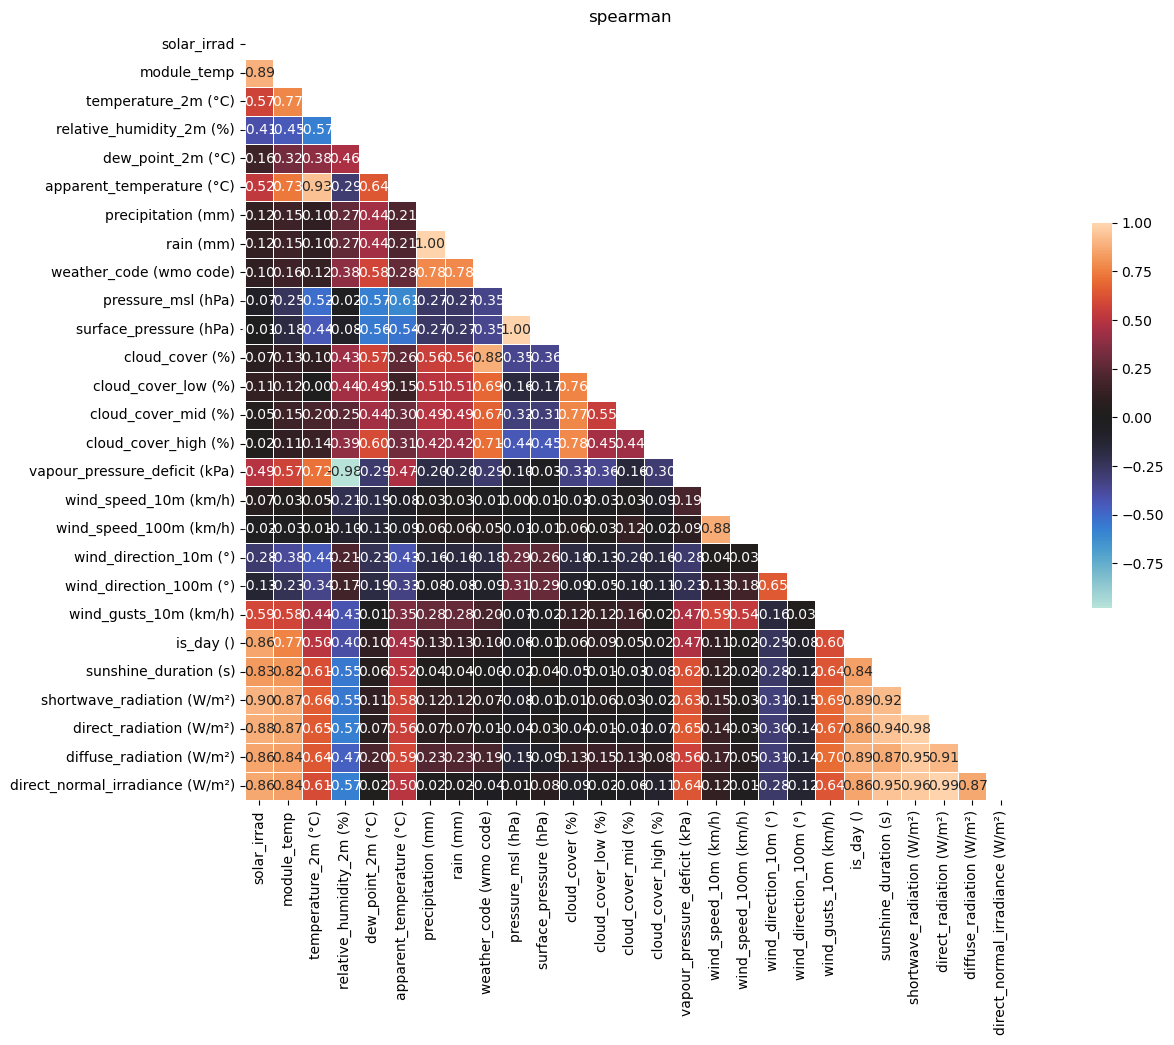

In [19]:
show_info(irradiance_weather_ts)

In [16]:
timestamp_for_split = pd.Timestamp(year=2023, month=4, day=1, tz=TIMEZONE)

In [20]:
segment = get_actual_forecast(irradiance_weather_ts, timestamp_for_split, 24)

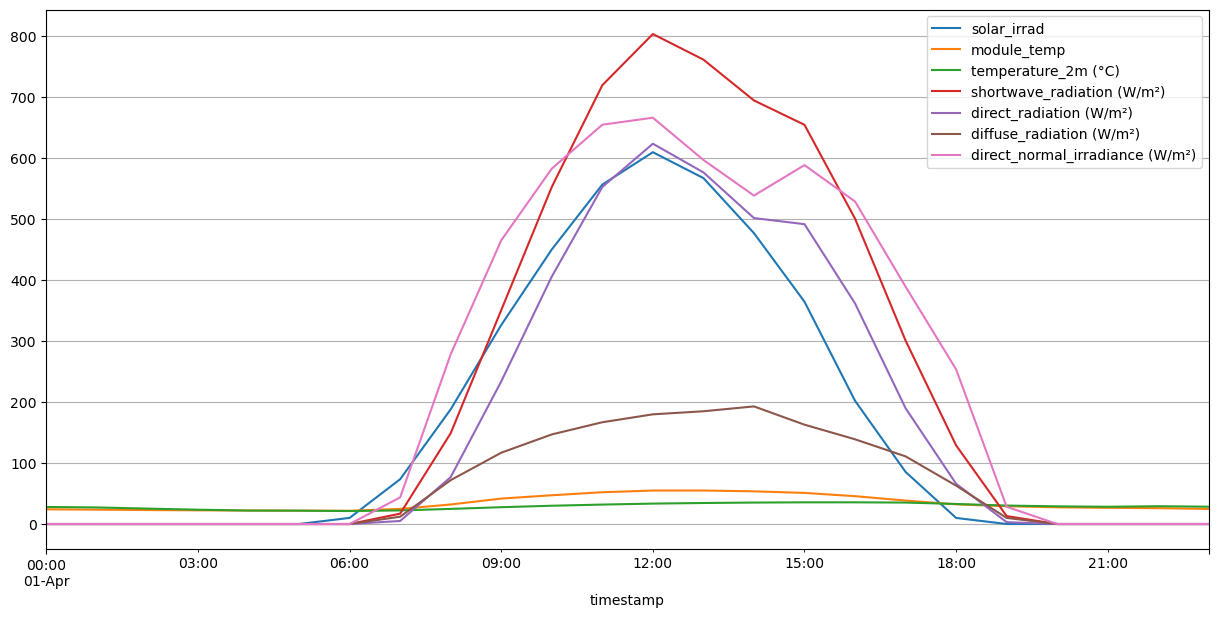

In [22]:
segment[[IRRAD_COLUMN, SENSOR_TEMP_COLUMN, TEMPERATURE, SHORTWAVE_RADIATION, DIRECT_RADIATION, DIFFUSE_RADIATION, DIRECT_NORMAL_IRRADIANCE]].plot(figsize=(15, 7))
plt.grid(True)
plt.show()

# Splitting

In [23]:
train_ts = irradiance_weather_ts[:timestamp_for_split]
test_ts = irradiance_weather_ts[timestamp_for_split:]

In [24]:
train_ts.to_csv(DATA_PATH + "train_irradiance_weather_history.csv")

In [28]:
# 6493 / (12661 + 6493) = 0.339

## collect_test_and_solution_data

In [42]:
def collect_test_data(test_timeseries: pd.DataFrame, history_length, forecast_length, value_column):
    test_ts_irradiance = pd.DataFrame(test_timeseries[value_column])
    test_ts_weather = test_timeseries.drop(columns=[value_column])
    lagged_table_irradiance = pd.DataFrame()
    usage_column_for_kaggle = "Public"
    timestamps = test_timeseries.index
    for timestamp in tqdm(timestamps):
        history = get_history(test_ts_irradiance, timestamp, history_length)
        forecast_actual = get_actual_forecast(test_ts_irradiance, timestamp, forecast_length)
        if history is None or forecast_actual is None:
            continue     
        irradiance_lagged_row = pd.DataFrame([ [usage_column_for_kaggle] + [timestamp] + list(history[value_column].values) + list(forecast_actual[value_column].values) ], 
                                               columns=["Usage"] + [TIMESTAMP_COLUMN] + [f"history_-{history_length-i}" for i in range(history_length)] +  [f"actual_{i}" for i in range(forecast_length)])
        lagged_table_irradiance = pd.concat([lagged_table_irradiance,  irradiance_lagged_row], ignore_index=True)
    return test_ts_irradiance, test_ts_weather, lagged_table_irradiance

In [43]:
test_ts_irradiance, test_ts_weather, lagged_table_irradiance = collect_test_data(test_ts, 
                                                                                 HISTORY_LENGTH, 
                                                                                 FORECAST_LENGTH, 
                                                                                 IRRAD_COLUMN)

100%|██████████| 6493/6493 [00:33<00:00, 195.53it/s]


In [44]:
test_ts_irradiance.head()

,solar_irrad
timestamp,
2023-04-01 00:00:00+07:00,0.025
2023-04-01 01:00:00+07:00,0.024
2023-04-01 02:00:00+07:00,0.017
2023-04-01 03:00:00+07:00,0.019
2023-04-01 04:00:00+07:00,0.016


In [45]:
test_ts_weather.head()

,module_temp,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),weather_code (wmo code),pressure_msl (hPa),surface_pressure (hPa),...,wind_speed_100m (km/h),wind_direction_10m (°),wind_direction_100m (°),wind_gusts_10m (km/h),is_day (),sunshine_duration (s),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²)
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-04-01 00:00:00+07:00,24.141,28.0,44,14.7,28.8,0.0,0.0,0,1007.9,973.3,...,6.2,70,100,6.5,0,0.0,0.0,0.0,0.0,0.0
2023-04-01 01:00:00+07:00,23.551,27.2,46,14.6,27.9,0.0,0.0,0,1007.7,973.0,...,7.3,58,101,6.8,0,0.0,0.0,0.0,0.0,0.0
2023-04-01 02:00:00+07:00,22.911,25.3,53,15.2,26.2,0.0,0.0,0,1007.4,972.5,...,5.6,360,63,7.6,0,0.0,0.0,0.0,0.0,0.0
2023-04-01 03:00:00+07:00,22.480,23.5,62,15.7,24.6,0.0,0.0,0,1007.3,972.2,...,4.5,346,29,8.6,0,0.0,0.0,0.0,0.0,0.0
2023-04-01 04:00:00+07:00,22.135,22.1,67,15.8,23.2,0.0,0.0,0,1007.4,972.1,...,5.9,350,14,9.4,0,0.0,0.0,0.0,0.0,0.0


In [46]:
lagged_table_irradiance.head()

,Usage,timestamp,history_-48,history_-47,history_-46,history_-45,history_-44,history_-43,history_-42,history_-41,...,actual_14,actual_15,actual_16,actual_17,actual_18,actual_19,actual_20,actual_21,actual_22,actual_23
0,Public,2023-04-03 00:00:00+07:00,0.025,0.024,0.017,0.019,0.016,0.016,10.039,73.513,...,551.863,286.091,277.618,93.489,13.226,0.053,0.046,0.038,0.038,0.027
1,Public,2023-04-03 01:00:00+07:00,0.024,0.017,0.019,0.016,0.016,10.039,73.513,188.200,...,286.091,277.618,93.489,13.226,0.053,0.046,0.038,0.038,0.027,0.025
2,Public,2023-04-03 02:00:00+07:00,0.017,0.019,0.016,0.016,10.039,73.513,188.200,326.496,...,277.618,93.489,13.226,0.053,0.046,0.038,0.038,0.027,0.025,0.025
3,Public,2023-04-03 03:00:00+07:00,0.019,0.016,0.016,10.039,73.513,188.200,326.496,450.515,...,93.489,13.226,0.053,0.046,0.038,0.038,0.027,0.025,0.025,0.022
4,Public,2023-04-03 04:00:00+07:00,0.016,0.016,10.039,73.513,188.200,326.496,450.515,556.955,...,13.226,0.053,0.046,0.038,0.038,0.027,0.025,0.025,0.022,0.016


In [47]:
lagged_table_irradiance_shuffled = lagged_table_irradiance.sample(frac=1, random_state=1).reset_index().drop(columns=["index"])

In [48]:
lagged_table_irradiance_shuffled.head()

,Usage,timestamp,history_-48,history_-47,history_-46,history_-45,history_-44,history_-43,history_-42,history_-41,...,actual_14,actual_15,actual_16,actual_17,actual_18,actual_19,actual_20,actual_21,actual_22,actual_23
0,Public,2023-06-23 19:00:00+07:00,0.376,0.018,0.022,0.019,0.022,0.017,0.018,0.015,...,444.979,732.315,494.481,437.078,379.381,393.196,132.699,67.286,79.012,33.143
1,Public,2023-08-28 02:00:00+07:00,0.015,0.017,0.023,0.053,27.122,126.667,421.463,575.631,...,159.699,66.489,9.765,0.048,0.042,0.041,0.040,0.039,0.036,0.027
2,Public,2023-11-04 20:00:00+07:00,0.029,0.027,0.029,0.028,0.016,0.017,0.018,0.012,...,558.943,712.982,688.381,530.386,367.444,169.239,142.495,15.324,0.084,0.038
3,Public,2023-12-07 11:00:00+07:00,591.818,593.937,547.138,412.687,261.768,88.970,16.369,0.045,...,0.016,0.021,0.017,0.012,0.009,3.492,35.444,125.194,180.542,371.111
4,Public,2023-10-04 03:00:00+07:00,0.034,0.030,0.033,34.358,220.085,464.255,578.845,447.150,...,57.982,0.874,0.051,0.046,0.048,0.051,0.035,0.034,0.023,0.022


In [49]:
test_table_irradiance = lagged_table_irradiance_shuffled.drop(columns=["Usage"] + [f"actual_{i}" for i in range(FORECAST_LENGTH)])
solution_table = lagged_table_irradiance_shuffled.drop(columns=[f"history_-{HISTORY_LENGTH-i}" for i in range(HISTORY_LENGTH)])

In [50]:
test_table_irradiance.head()

,timestamp,history_-48,history_-47,history_-46,history_-45,history_-44,history_-43,history_-42,history_-41,history_-40,...,history_-10,history_-9,history_-8,history_-7,history_-6,history_-5,history_-4,history_-3,history_-2,history_-1
0,2023-06-23 19:00:00+07:00,0.376,0.018,0.022,0.019,0.022,0.017,0.018,0.015,0.014,...,460.010,603.035,666.618,541.603,561.169,416.243,440.701,281.811,237.527,55.216
1,2023-08-28 02:00:00+07:00,0.015,0.017,0.023,0.053,27.122,126.667,421.463,575.631,296.369,...,234.135,111.242,19.060,0.035,0.034,0.048,0.046,0.044,0.030,0.037
2,2023-11-04 20:00:00+07:00,0.029,0.027,0.029,0.028,0.016,0.017,0.018,0.012,0.011,...,639.551,728.701,662.878,627.775,348.631,303.627,182.935,25.643,0.120,0.044
3,2023-12-07 11:00:00+07:00,591.818,593.937,547.138,412.687,261.768,88.970,16.369,0.045,0.029,...,0.023,0.014,0.023,0.029,0.019,2.362,50.507,181.604,324.707,406.153
4,2023-10-04 03:00:00+07:00,0.034,0.030,0.033,34.358,220.085,464.255,578.845,447.150,643.930,...,34.370,1.756,0.052,0.048,0.039,0.040,0.043,0.039,0.037,0.032


In [51]:
solution_table.head()

,Usage,timestamp,actual_0,actual_1,actual_2,actual_3,actual_4,actual_5,actual_6,actual_7,...,actual_14,actual_15,actual_16,actual_17,actual_18,actual_19,actual_20,actual_21,actual_22,actual_23
0,Public,2023-06-23 19:00:00+07:00,0.511,0.040,0.042,0.037,0.043,0.038,0.041,0.039,...,444.979,732.315,494.481,437.078,379.381,393.196,132.699,67.286,79.012,33.143
1,Public,2023-08-28 02:00:00+07:00,0.035,0.037,0.046,0.053,11.588,109.388,291.199,524.544,...,159.699,66.489,9.765,0.048,0.042,0.041,0.040,0.039,0.036,0.027
2,Public,2023-11-04 20:00:00+07:00,0.041,0.030,0.024,0.024,0.016,0.019,0.013,0.011,...,558.943,712.982,688.381,530.386,367.444,169.239,142.495,15.324,0.084,0.038
3,Public,2023-12-07 11:00:00+07:00,540.276,517.021,521.774,306.833,97.364,70.136,12.163,0.042,...,0.016,0.021,0.017,0.012,0.009,3.492,35.444,125.194,180.542,371.111
4,Public,2023-10-04 03:00:00+07:00,0.021,0.024,0.036,28.786,206.123,430.097,632.064,761.185,...,57.982,0.874,0.051,0.046,0.048,0.051,0.035,0.034,0.023,0.022


In [52]:
number_of_test_cases = len(solution_table)
sample_submission_table = pd.DataFrame({f"forecast_{i}": list(range(number_of_test_cases)) for i in range(FORECAST_LENGTH)})
sample_submission_table[TIMESTAMP_COLUMN] = solution_table[TIMESTAMP_COLUMN]
sample_submission_table = sample_submission_table.set_index(TIMESTAMP_COLUMN).reset_index()

In [53]:
sample_submission_table.head()

,timestamp,forecast_0,forecast_1,forecast_2,forecast_3,forecast_4,forecast_5,forecast_6,forecast_7,forecast_8,...,forecast_14,forecast_15,forecast_16,forecast_17,forecast_18,forecast_19,forecast_20,forecast_21,forecast_22,forecast_23
0,2023-06-23 19:00:00+07:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2023-08-28 02:00:00+07:00,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,2023-11-04 20:00:00+07:00,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
3,2023-12-07 11:00:00+07:00,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
4,2023-10-04 03:00:00+07:00,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4


In [54]:
test_table_irradiance.to_csv("data/test_cases_irradiance.csv")
test_ts_weather.to_csv("data/test_weather_time_series.csv")
solution_table.to_csv("data/solution_table_irradiance.csv")
sample_submission_table.to_csv("data/sample_submission_table_irradiance.csv")